### Library imports

In [1]:
!pip install -qqq wandb --upgrade  # upgrade wand on colab
!pip install -qqqU fastai  --upgrade  # upgrade fastai on colab
!pip install -qqqU timm -q --upgrade  # upgrade timm on colab


     |████████████████████████████████| 1.8MB 3.8MB/s 
     |████████████████████████████████| 102kB 6.7MB/s 
     |████████████████████████████████| 133kB 11.1MB/s 
     |████████████████████████████████| 174kB 12.6MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 194kB 3.8MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 378kB 3.9MB/s 


In [2]:
from fastai.vision.all import *
from pathlib import Path
from timm import create_model
from google.colab import drive
import wandb
from fastai.callback.wandb import *

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Initializing random seed

In [4]:
SEED=2021
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)
torch.backends.cudnn.benchmark = True

### Loading and preprocessing data

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = Path("/content/drive/My Drive/ML/severstal")

codes = ["Background", "Divots", "Cracks", "Scratches", "Ablation"]

def get_mask(fn):
    fn = Path(str(fn).replace('train_images', 'masks').replace('jpg','png'))
    return PILMask.create(fn)


### Using custom stats to normalize data

In [7]:
severstal_stats=([0.343], [0.197])

### Creating datablock to read grayscale images and target masks

In [8]:
def get_dls(size, batch_size=8):
  
  dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                     get_items=get_image_files,
                     get_y = get_mask,
                     batch_tfms=[*aug_transforms(size=size,flip_vert=True), Normalize.from_stats(*severstal_stats)])
  
  return dblock.dataloaders(path/'train_images', batch_size=batch_size)

In [27]:
sz = (256, 512) # As per 1st place solution
bs = 4          # 1st place solution proposes 12 or 24 with grad accumulation at 24 samples

dls = get_dls(size=sz, batch_size=bs)

In [ ]:
xb, yb = first(dls.train)
xb.shape, yb.shape

(torch.Size([4, 3, 256, 512]), torch.Size([4, 256, 512]))

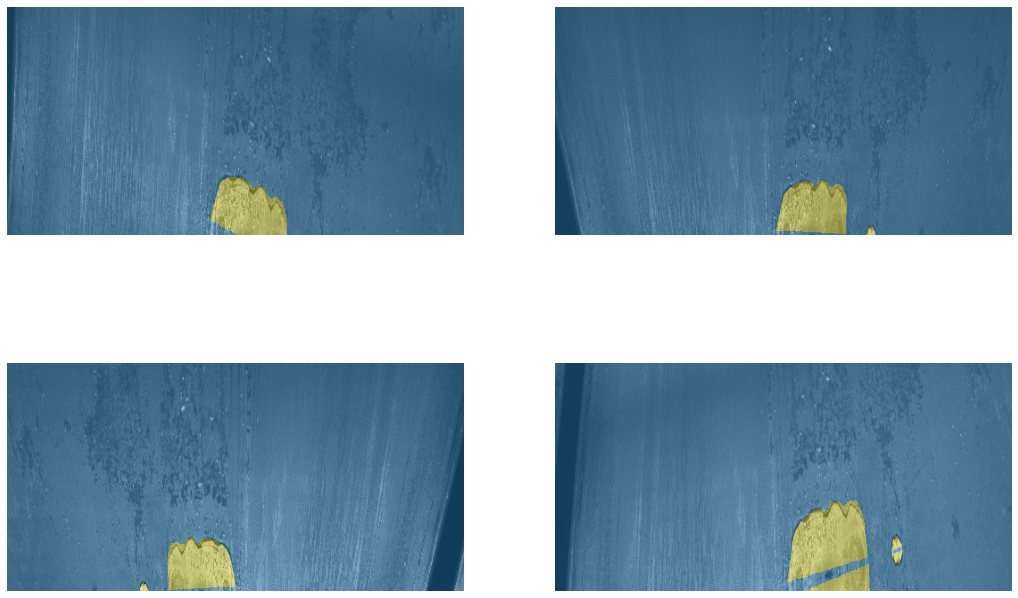

In [ ]:
dls.show_batch(unique=True, figsize=(18,12))

### (TODO) Loading EfficientNet model for segmentation backbone 

In [20]:
class Encoder(nn.Module):
  def __init__(self, model_name='efficientnet_b3'):
    super(Encoder, self).__init__()
    self.encoder=create_model(model_name, features_only=True,  pretrained=True)

  def forward(self, x):
    return self.encoder(x)


In [21]:
model = Encoder('efficientnet_b3')

### Creating custom loss function class

In [24]:
class DiceLoss:
    "Dice loss for segmentation"
    def __init__(self, axis=1, smooth=1):
        store_attr()
    def __call__(self, pred, targ):
        targ = self._one_hot(targ, pred.shape[self.axis])
        pred, targ = flatten_check(self.activation(pred), targ)
        inter = (pred*targ).sum()
        union = (pred+targ).sum()
        return 1 - (2. * inter + self.smooth)/(union + self.smooth)
    @staticmethod
    def _one_hot(x, classes, axis=1):
        "Creates one binay mask per class"
        return torch.stack([torch.where(x==c, 1, 0) for c in range(classes)], axis=axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)
    def decodes(self, x):    return x.argmax(dim=self.axis)

In [25]:
class CustomComboLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=0.75):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)       
    def __call__(self, pred, targ):
        return (self.alpha * self.focal_loss(pred, targ)) + ((1-self.alpha) * self.dice_loss(pred, targ))
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

### Customizing Dice metric to handle one-hot encoded masks

In [22]:
class Dice(Metric):
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1, smooth=1., num_classes=5): self.axis, self.num_classes, self.smooth = axis, num_classes, smooth
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
      targ = self._one_hot(learn.y, classes=self.num_classes)
      pred,targ = flatten_check(learn.pred, targ)
      self.inter += (pred*targ).float().sum().item()
      self.union += (pred+targ).float().sum().item()
    @staticmethod
    def _one_hot(x, classes, axis=1):
        "Creates one binay mask per class"
        return torch.stack([torch.where(x==c, 1, 0) for c in range(classes)], axis=axis)
    @property
    def value(self): return (2. * self.inter + self.smooth)/(self.union + self.smooth)

### Intializing Wand

In [23]:
wandb.init(project='severstal-fastai-project');

wandb: Currently logged in as: bilalcodehub (use `wandb login --relogin` to force relogin)


### Training - Learner with Adam optimizer & Resnet34 architecture

In [ ]:
learn = unet_learner(dls, resnet34, loss_func=CustomComboLoss(), metrics=[Dice, DiceMulti])
learn.fine_tune(10)

epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.075626,0.064263,-0.321304,0.196798,06:24


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.051976,0.043462,-0.217878,0.297765,06:47
1,0.055912,0.047856,-0.388098,0.293355,06:47
2,0.049024,0.046364,-0.238660,0.316625,06:49
3,0.037119,0.036229,-0.117850,0.464156,06:50
4,0.036882,0.032792,-0.067471,0.472781,06:51
5,0.038019,0.030489,-0.087419,0.468722,06:50
6,0.027308,0.026558,-0.023805,0.477683,06:50
7,0.032110,0.025758,0.005810,0.531973,06:50
8,0.030279,0.024969,0.029101,0.531939,06:49
9,0.029992,0.025217,0.033321,0.539241,06:50


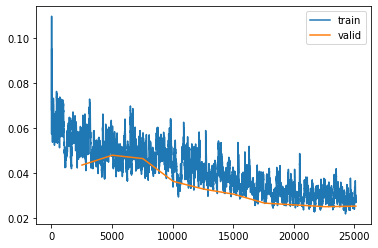

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [ ]:
learn.unfreeze()

SuggestedLRs(valley=tensor(1.2023e-05))

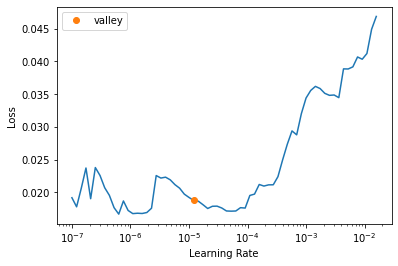

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, base_lr=1e-5)

epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.032092,0.024336,0.034877,0.548308,06:31


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.025685,0.024323,0.034258,0.554462,06:48
1,0.025021,0.025720,0.034209,0.544968,06:48
2,0.027808,0.025581,0.040191,0.546499,06:47
3,0.026094,0.024175,0.039738,0.545008,06:47
4,0.027901,0.025134,0.040660,0.535538,06:47
5,0.030451,0.024130,0.040604,0.555579,06:47
6,0.029295,0.025184,0.041589,0.542846,06:48
7,0.029438,0.024274,0.040725,0.542552,06:48
8,0.023339,0.024232,0.040678,0.550304,06:48
9,0.027550,0.024544,0.041625,0.536157,06:48


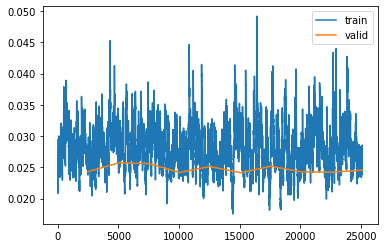

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('model_1')

Path('models/model_1.pth')

### Training - Learner with RAdam optimizer & Resnet34 architecture


In [ ]:
learn = unet_learner(dls, resnet34, opt_func = RAdam, loss_func=CustomComboLoss(), metrics=[Dice, DiceMulti])

SuggestedLRs(valley=tensor(0.0003))

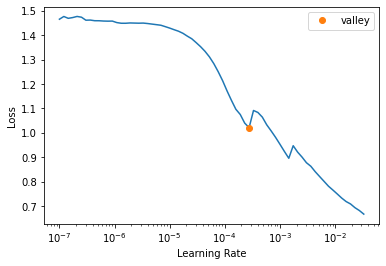

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.077152,0.065079,-0.383100,0.196720,06:22


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.061376,0.041874,-0.327208,0.271672,06:46
1,0.046121,0.036493,-0.227188,0.361280,06:46
2,0.040543,0.037025,-0.162950,0.305461,06:46
3,0.044768,0.035768,-0.050203,0.412624,06:46
4,0.050943,0.036806,0.024197,0.445536,06:47
5,0.030346,0.030047,-0.002212,0.425896,06:47
6,0.033609,0.027359,0.065022,0.477856,06:47
7,0.023499,0.027434,0.084604,0.510293,06:47
8,0.032476,0.025324,0.080061,0.502470,06:47
9,0.029867,0.025588,0.092190,0.516274,06:47


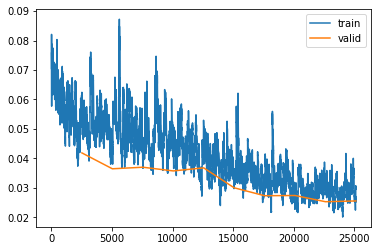

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('radam-stage-1')

Path('models/radam-stage-1.pth')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fine_tune(10, base_lr=1e-5)

epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.024206,0.026034,0.089521,0.514239,06:29


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.029559,0.024415,0.090699,0.530777,06:47
1,0.023084,0.025404,0.096340,0.528609,06:47
2,0.032307,0.024966,0.095554,0.528721,06:47
3,0.026033,0.025970,0.095236,0.521011,06:47
4,0.030627,0.024748,0.100814,0.521683,06:47
5,0.025879,0.024369,0.097408,0.526134,06:47
6,0.036323,0.024443,0.098549,0.531075,06:46
7,0.028538,0.024353,0.100541,0.511177,06:47
8,0.023797,0.025324,0.096082,0.521909,06:47
9,0.033111,0.025836,0.094731,0.519793,06:47


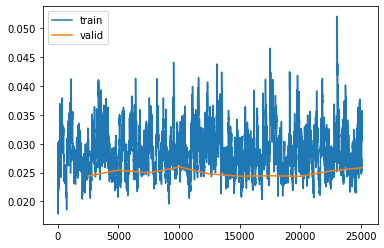

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('radam-model_1')

Path('models/radam-model_1.pth')

### Training - Learner with Adam optimizer & ReXnet34 architecture

In [ ]:
learn = unet_learner(dls, xresnet34, loss_func=CustomComboLoss(), metrics=[Dice, DiceMulti])

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=tensor(7.5858e-05))

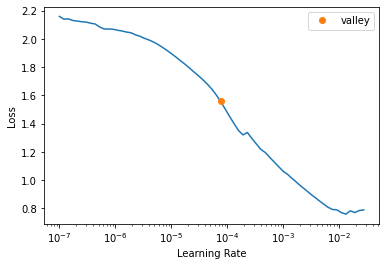

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, base_lr=1e-5)

epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.070401,0.072908,1.283291,0.223342,43:14


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.071236,0.062020,1.309234,0.253097,07:03
1,0.073550,0.058899,1.318644,0.264346,06:59
2,0.064960,0.059031,1.301644,0.274462,06:59
3,0.061677,0.056146,1.604955,0.276362,06:59
4,0.052872,0.054305,1.702751,0.279794,07:01
5,0.060085,0.052092,1.408932,0.275097,07:03
6,0.054096,0.049175,1.467422,0.300655,06:59
7,0.057213,0.047349,1.443192,0.319553,06:56
8,0.045743,0.046630,1.468505,0.327182,06:58
9,0.051492,0.045968,1.475706,0.329086,07:00


In [ ]:
learn.fine_tune(10, base_lr=1e-2)

epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.084930,0.078322,-0.131825,0.197652,06:36


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.074314,0.070655,-0.171619,0.243746,07:00
1,0.073754,0.078434,-0.126399,0.223780,06:57
2,0.070147,0.068699,-0.077181,0.233773,06:57
3,0.067225,0.068760,-0.136059,0.239381,06:57
4,0.070882,0.067921,0.005656,0.233611,06:58
5,0.078471,0.063989,-0.021396,0.229929,06:57
6,0.068263,0.060972,-0.019664,0.261287,06:56
7,0.067459,0.057911,-0.034756,0.251221,06:57
8,0.048142,0.058233,-0.027008,0.262210,06:55
9,0.051904,0.055061,-0.015403,0.278607,06:56


### Gradient Accumulation

In [ ]:
learn = unet_learner(dls, resnet34, loss_func=CustomComboLoss(), metrics=[Dice, DiceMulti], cbs=[GradientAccumulation(n_acc=24), WandbCallback(log_dataset=True, log_model=True), SaveModelCallback()])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.065284,0.060515,-1.143196,0.267366,40:40


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.046784,0.047431,-1.106376,0.312439,06:34
1,0.055947,0.042748,-1.169093,0.244665,06:31
2,0.044732,0.034890,-1.098984,0.413569,06:34
3,0.042665,0.033621,-0.876034,0.317297,06:34
4,0.037077,0.030095,-0.823194,0.430660,06:34
5,0.042667,0.027459,-0.892504,0.438333,06:34
6,0.031820,0.026669,-0.830666,0.478568,06:32
7,0.032773,0.024860,-0.786745,0.540730,06:31
8,0.026619,0.023873,-0.759559,0.538898,06:32
9,0.032987,0.023610,-0.748340,0.524368,06:33


In [ ]:
learn = unet_learner(dls, resnet34, loss_func=CustomComboLoss(), metrics=[Dice, DiceMulti], opt_func=RAdam, cbs=[GradientAccumulation(n_acc=24), WandbCallback(log_dataset=True, log_model=True), SaveModelCallback()])

SuggestedLRs(valley=tensor(0.0002))

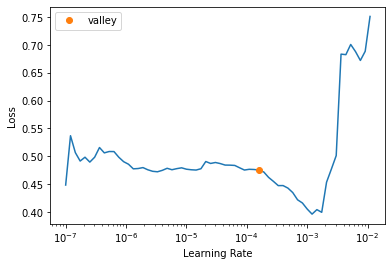

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(5, base_lr=1e-4)

epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.085059,0.066581,3.213462,0.204089,06:12


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.064327,0.049680,3.172125,0.255471,06:30
1,0.059412,0.040686,3.981072,0.302773,06:29
2,0.042728,0.037616,3.713240,0.414464,06:29
3,0.051107,0.035001,3.915806,0.398493,06:30
4,0.047875,0.033532,3.513328,0.411524,06:30


SuggestedLRs(valley=tensor(0.0001))

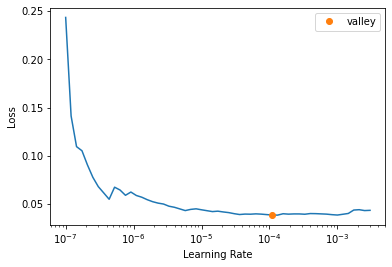

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, base_lr=1e-4)

epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.057219,0.035502,4.616237,0.312585,06:13


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.042164,0.036092,4.807133,0.412156,06:30
1,0.047229,0.039191,4.203654,0.373586,06:33
2,0.045859,0.035830,4.460380,0.361240,06:34
3,0.040562,0.032228,4.499049,0.391685,06:34
4,0.044072,0.030650,4.999853,0.446051,06:32
5,0.034545,0.029863,4.758870,0.440739,06:31
6,0.037747,0.028848,5.202265,0.477392,06:32
7,0.038557,0.028373,6.144966,0.466592,06:32
8,0.034538,0.027403,5.842957,0.484785,06:35
9,0.033393,0.027293,5.918073,0.485259,06:35


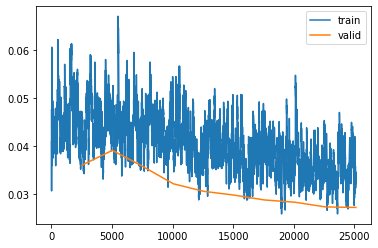

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('radam-ga-model_1')

Path('models/radam-ga-model_1.pth')

In [ ]:
learn = unet_learner(dls, resnet34, loss_func=CustomComboLoss(), metrics=[Dice, DiceMulti], cbs=[GradientAccumulation(n_acc=24), WandbCallback(log_model=True), SaveModelCallback()])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=tensor(2.0893e-05))

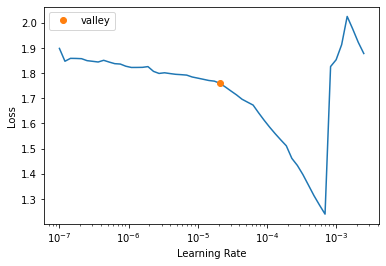

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-4)

WandbCallback could not retrieve the dataset path, please provide it explicitly to "log_dataset"


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.069378,0.071794,3.051269,0.204740,42:24
1,0.077822,0.070729,3.837121,0.283738,06:36
2,0.049025,0.044251,7.404021,0.306179,06:40
3,0.045385,0.042234,44.005566,0.305005,06:37
4,0.042657,0.036998,31.134986,0.371484,06:39
5,0.046451,0.034783,-38.356603,0.416839,06:39
6,0.043240,0.032873,-22.353440,0.449453,06:41
7,0.048224,0.032102,-13.262307,0.418733,06:42
8,0.051800,0.030839,-16.123284,0.445882,06:41
9,0.035200,0.031108,-13.609133,0.456448,06:37


Better model found at epoch 0 with valid_loss value: 0.07179433852434158.
Better model found at epoch 1 with valid_loss value: 0.07072886824607849.
Better model found at epoch 2 with valid_loss value: 0.04425105080008507.
Better model found at epoch 3 with valid_loss value: 0.0422338992357254.
Better model found at epoch 4 with valid_loss value: 0.036998357623815536.
Better model found at epoch 5 with valid_loss value: 0.03478299081325531.
Better model found at epoch 6 with valid_loss value: 0.032872579991817474.
Better model found at epoch 7 with valid_loss value: 0.03210153430700302.
Better model found at epoch 8 with valid_loss value: 0.030838672071695328.


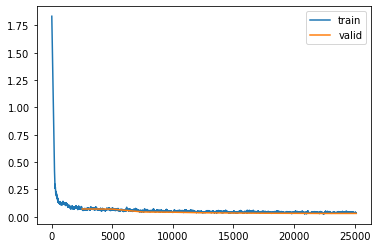

In [ ]:
learn.recorder.plot_loss()

In [ ]:
wandb.finish()

epoch,10
train_loss,0.0352
raw_loss,0.03384
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
wd_1,0.01
sqr_mom_1,0.99
lr_1,0.0


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▂▂▃▂▂▃▃▄▂▄▆▃▂▁▁▂▂▂▂▂▂▂▁▁▃▂▂▂▁▁▁▂▁▂▁▁▂▁▂
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▆▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁


In [ ]:
sz = (256, 512) # As per 1st place solution
bs = 2          # 1st place solution proposes 12 or 24 with grad accumulation at 24 samples

dls = get_dls(size=sz, batch_size=bs)

In [ ]:
learn = unet_learner(dls, resnet50, loss_func=CustomComboLoss(), metrics=[Dice, DiceMulti], cbs=[GradientAccumulation(n_acc=12), WandbCallback(log_model=True), SaveModelCallback()])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=tensor(1.0000e-05))

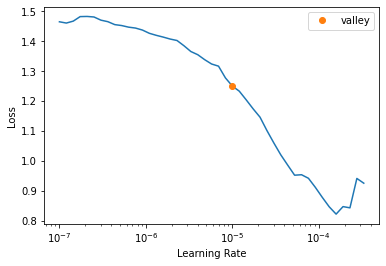

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-5/12

In [ ]:
learn.fine_tune(10, base_lr=lr)

epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.072956,0.079723,4.137529,0.210364,40:06


Better model found at epoch 0 with valid_loss value: 0.07972273975610733.


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.060034,0.073537,4.509872,0.213040,41:28
1,0.078089,0.065603,4.794318,0.233770,41:29
2,0.062643,0.058995,5.149563,0.267547,41:26
3,0.062828,0.059186,5.492439,0.271169,41:21
4,0.066551,0.056077,5.618281,0.287418,41:23
5,0.071102,0.051154,5.580495,0.313333,41:15
6,0.075815,0.052451,5.559468,0.313442,41:12
7,0.055404,0.051381,5.801602,0.327164,41:11
8,0.050718,0.050472,5.601335,0.328108,41:14
9,0.051713,0.050190,5.612376,0.327778,41:15


Better model found at epoch 0 with valid_loss value: 0.07353711128234863.
Better model found at epoch 1 with valid_loss value: 0.06560255587100983.
Better model found at epoch 2 with valid_loss value: 0.05899488180875778.
Better model found at epoch 4 with valid_loss value: 0.056077465415000916.
Better model found at epoch 5 with valid_loss value: 0.05115431547164917.
Better model found at epoch 8 with valid_loss value: 0.050472158938646317.
Better model found at epoch 9 with valid_loss value: 0.050189513713121414.


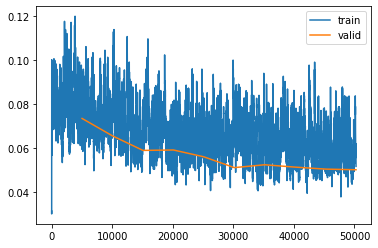

In [ ]:
learn.recorder.plot_loss()

In [ ]:
wandb.finish()

In [ ]:
sz = (256, 512) # As per 1st place solution
bs = 2          # 1st place solution proposes 12 or 24 with grad accumulation at 24 samples

dls = get_dls(size=sz, batch_size=bs)

In [ ]:
learn = unet_learner(dls, xresnet34, loss_func=CustomComboLoss(), metrics=[Dice, DiceMulti], cbs=[GradientAccumulation(n_acc=12), WandbCallback(log_model=True), SaveModelCallback()])

SuggestedLRs(valley=tensor(4.3652e-05))

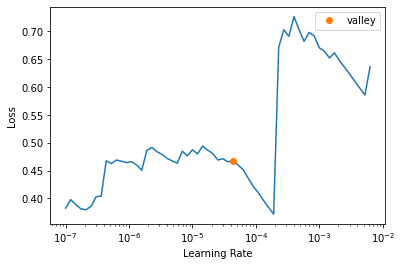

In [ ]:
learn.lr_find()

In [ ]:
lr=5e-4

In [ ]:
learn.fine_tune(10, base_lr=lr)

epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.068669,0.068009,-1.743934,0.237216,08:39


Better model found at epoch 0 with valid_loss value: 0.06800907850265503.


epoch,train_loss,valid_loss,dice,dice_multi,time
0,0.051468,0.060128,-2.403500,0.262510,09:26
1,0.074571,0.056199,-1.953485,0.248388,09:27
2,0.081847,0.060381,-1.600861,0.280957,09:27
3,0.050880,0.050204,-1.299205,0.295330,09:25


Better model found at epoch 0 with valid_loss value: 0.06012813001871109.
Better model found at epoch 1 with valid_loss value: 0.0561990924179554.
Better model found at epoch 3 with valid_loss value: 0.050204090774059296.


In [ ]:
learn.recorder.plot_loss()

In [ ]:
wandb.finish()